In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
days = pd.date_range(start='2024-01-01', periods=120) # 120 days i.e., 4 months
sample_size = np.random.randint(80,160,size=120)
true_defect_rate = 0.05

defect_count = np.random.binomial(sample_size, true_defect_rate)

df = pd.DataFrame({
    'Date': days,
    'Sample_Size': sample_size,
    'Defects': defect_count
})

df['Defect_Rate'] = df['Defects'] / df['Sample_Size']
df.head()

,Date,Sample_Size,Defects,Defect_Rate
0,2024-01-01,131,8,0.061069
1,2024-01-02,94,2,0.021277
2,2024-01-03,151,7,0.046358
3,2024-01-04,140,5,0.035714
4,2024-01-05,100,8,0.080000


In [2]:
p_bar = df['Defects'].sum() / df['Sample_Size'].sum()

df['p_bar'] = p_bar
df['UCL'] = p_bar + 3* np.sqrt((p_bar * (1-p_bar)) / df['Sample_Size'])
df['LCL'] = p_bar - 3* np.sqrt((p_bar * (1-p_bar)) / df['Sample_Size'])
df['LCL'] = df['LCL'].clip(lower=0)

In [3]:
df.head()

,Date,Sample_Size,Defects,Defect_Rate,p_bar,UCL,LCL
0,2024-01-01,131,8,0.061069,0.051655,0.109667,0.0
1,2024-01-02,94,2,0.021277,0.051655,0.120139,0.0
2,2024-01-03,151,7,0.046358,0.051655,0.105689,0.0
3,2024-01-04,140,5,0.035714,0.051655,0.107772,0.0
4,2024-01-05,100,8,0.080000,0.051655,0.118053,0.0


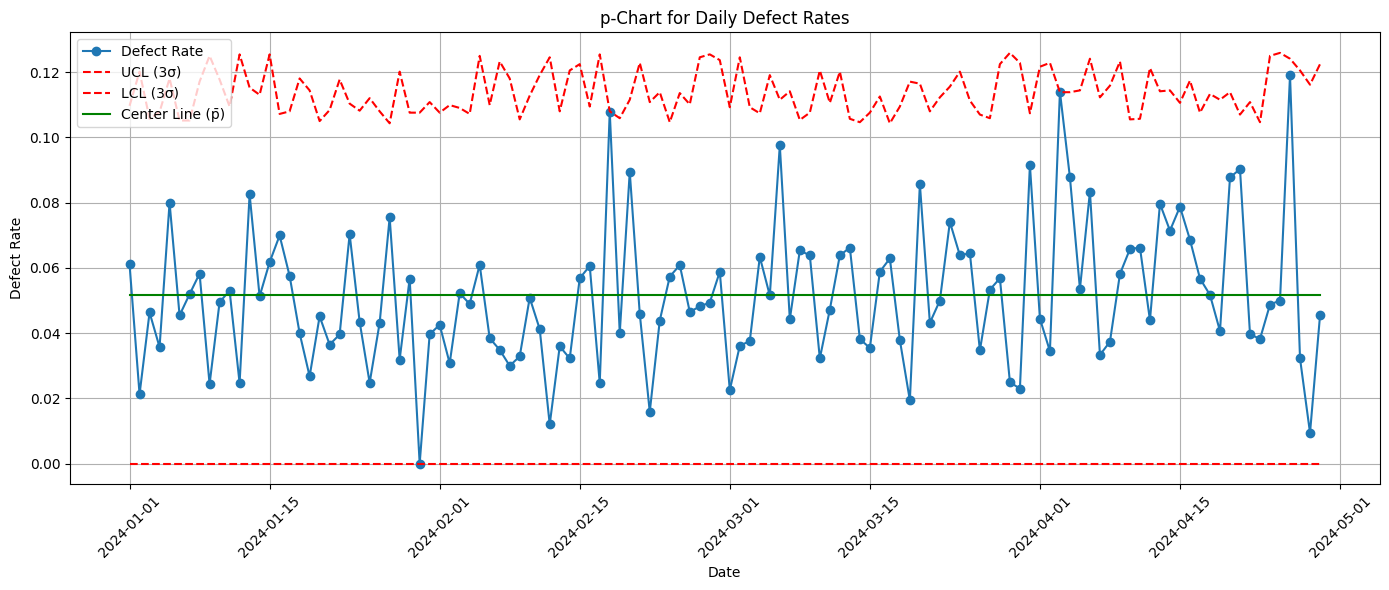

In [5]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label = 'Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')
plt.title('p-Chart for Daily Defect Rates')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
df['Out_of_Control'] = (df['Defect_Rate'] > df['UCL']) | (df['Defect_Rate'] < df['LCL'])
print(df[df['Out_of_Control']][['Date', 'Defect_Rate', 'UCL', 'LCL']])

         Date  Defect_Rate       UCL  LCL
93 2024-04-03     0.114035  0.113842  0.0


In [9]:
from statsmodels.stats.proportion import proportions_ztest

last = df.iloc[-1]
count = last['Defects']
nobs = last['Sample_Size']

stat, p_val = proportions_ztest(count, nobs, value=p_bar, alternative='larger')
print(f"Z-Stat: {stat:.2f}, p_val: {p_val:.4f}")

if p_val < 0.05:
    print("Statistically Significant increase in defects!")
else:
    print("No Significant Shift Detected.")

Z-Stat: -0.28, p_val: 0.6100
No Significant Shift Detected.


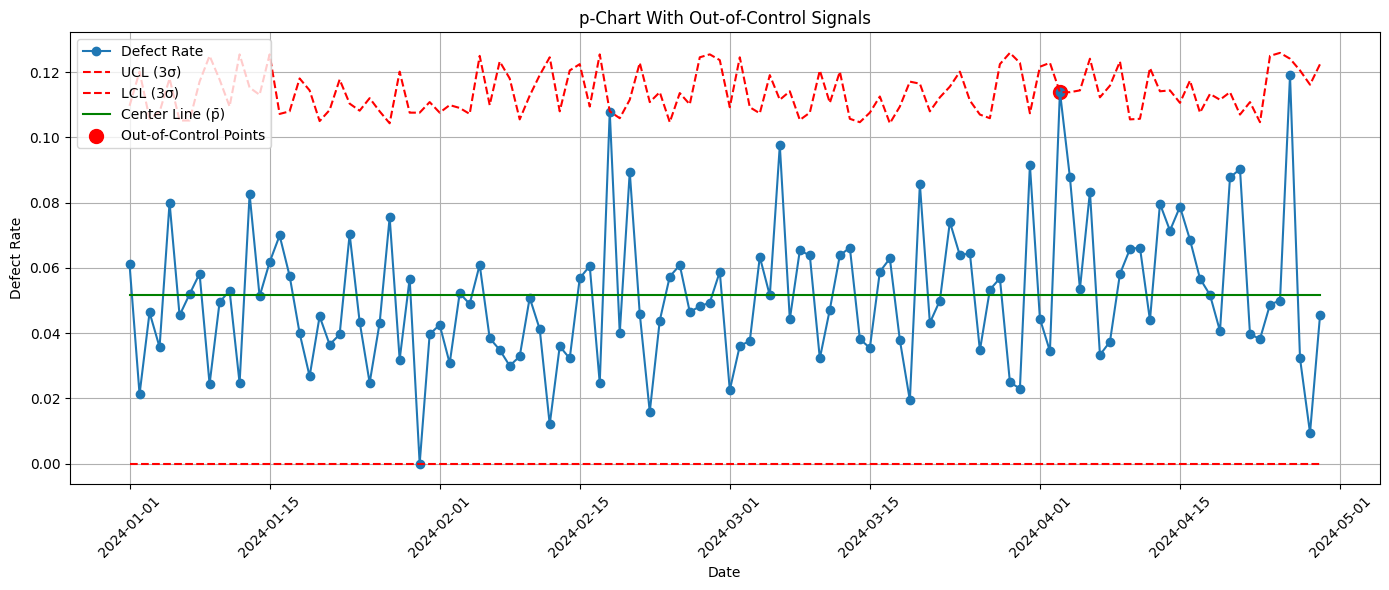

In [12]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label = 'Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')

out = df[df['Out_of_Control']]
plt.scatter(out['Date'], out['Defect_Rate'], color='red',s=100, label='Out-of-Control Points')

plt.title('p-Chart With Out-of-Control Signals')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
df.loc[75:, 'Defects'] = np.random.binomial(df.loc[75:, 'Sample_Size'], 0.12)
df['Defect_Rate'] = df['Defects'] / df['Sample_Size']

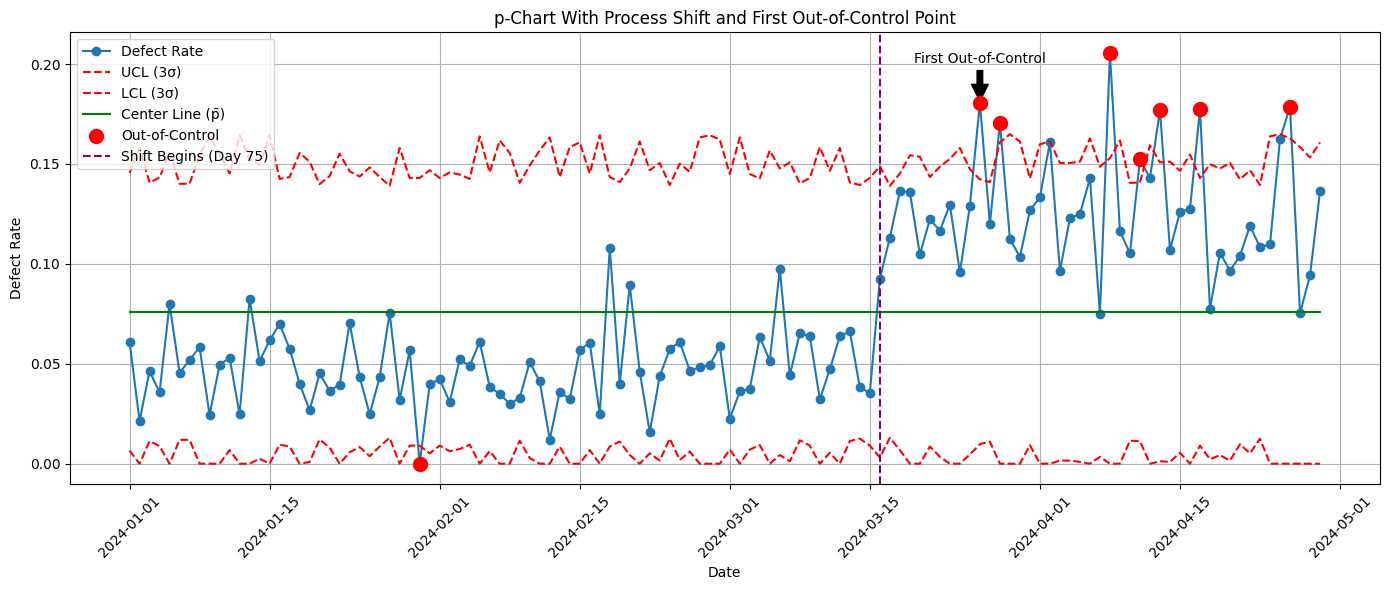

In [14]:
p_bar = df['Defects'].sum() / df['Sample_Size'].sum()
df['p_bar'] = p_bar
df['UCL'] = p_bar + 3* np.sqrt((p_bar * (1-p_bar)) / df['Sample_Size'])
df['LCL'] = p_bar - 3* np.sqrt((p_bar * (1-p_bar)) / df['Sample_Size'])
df['LCL'] = df['LCL'].clip(lower=0)

df['Out_of_Control'] = (df['Defect_Rate'] > df['UCL']) | (df['Defect_Rate'] < df['LCL'])
out_points = df[df['Out_of_Control']]

first_shift_index = 75
first_out_after_shift = df.loc[first_shift_index:].query("Out_of_Control").head(1)

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label = 'Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')
plt.scatter(out_points['Date'], out_points['Defect_Rate'], color='red',s=100, zorder=5, label='Out-of-Control')
plt.axvline(df['Date'].iloc[first_shift_index], color='purple', linestyle='--', label='Shift Begins (Day 75)')

if not first_out_after_shift.empty:
    x = first_out_after_shift['Date'].values[0]
    y = first_out_after_shift['Defect_Rate'].values[0]
    plt.annotate(
        'First Out-of-Control',
        xy = (x,y),
        xytext=(x, y + 0.02),
        arrowprops = dict(facecolor='black', shrink=0.05),
        fontsize = 10,
        ha='center'
    )

plt.title('p-Chart With Process Shift and First Out-of-Control Point')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
df['sigma'] = np.sqrt((df['p_bar'] * (1 - df['p_bar'])) / df['Sample_Size'])
df['Upper_1sigma'] = df['p_bar'] + df['sigma']
df['Lower_1sigma'] = df['p_bar'] - df['sigma']
df['Upper_2sigma'] = df['p_bar'] + 2 * df['sigma']
df['Lower_2sigma'] = df['p_bar'] - 2 * df['sigma']

df['Rule1'] = (df['Defect_Rate'] > df['UCL']) | (df['Defect_Rate'] < df['LCL'])

rule2_flags = [False] * len(df)
for i in range(2, len(df)):
    upper = (df.loc[i-2:i, 'Defect_Rate'] > df.loc[i-2:i, 'Upper_2sigma']).sum()
    lower = (df.loc[i-2:i, 'Defect_Rate'] < df.loc[i-2:i, 'Lower_2sigma']).sum()
    rule2_flags[i] = (upper >= 2) or (lower >= 2)
df['Rule2'] = rule2_flags

df['Above_Center'] = df['Defect_Rate'] > df['p_bar']
run_lengths = [1]
for i in range(1, len(df)):
    if df.loc[i, 'Above_Center'] == df.loc[i-1, 'Above_Center']:
        run_lengths.append(run_lengths[-1] + 1)
    else:
        run_lengths.append(1)
df['Run_Length'] = run_lengths
df['Rule4'] = df['Run_Length'] >= 8

df['Any_Rule_Violation'] = df[['Rule1', 'Rule2', 'Rule4']].any(axis=1)

violations = df[df['Any_Rule_Violation']]
print(violations[['Date', 'Defect_Rate', 'Rule1', 'Rule2', 'Rule4']])

          Date  Defect_Rate  Rule1  Rule2  Rule4
20  2024-01-21     0.036496  False  False   True
21  2024-01-22     0.039604  False  False   True
22  2024-01-23     0.070312  False  False   True
23  2024-01-24     0.043478  False  False   True
24  2024-01-25     0.024793  False  False   True
..         ...          ...    ...    ...    ...
113 2024-04-23     0.108280  False  False   True
114 2024-04-24     0.109756  False  False   True
115 2024-04-25     0.162500  False  False   True
116 2024-04-26     0.178571   True   True   True
117 2024-04-27     0.075269  False   True  False

[73 rows x 5 columns]


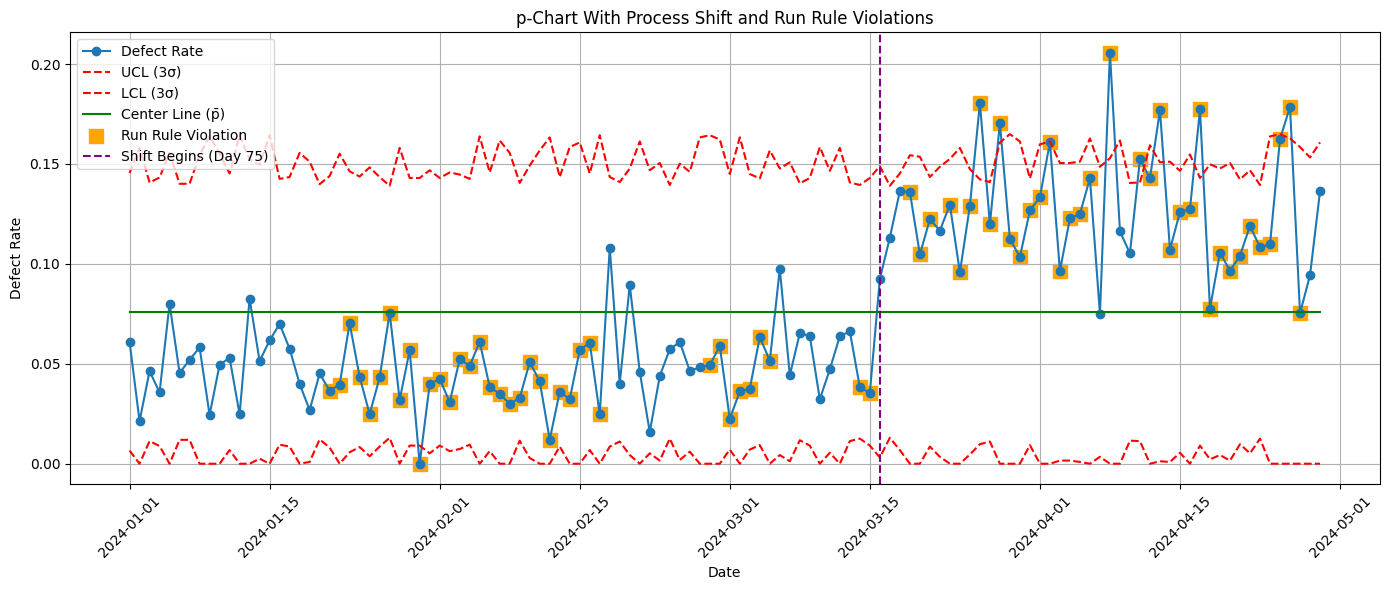

In [16]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label = 'Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')

plt.scatter(violations['Date'], violations['Defect_Rate'], color='orange',s=100, marker='s', label='Run Rule Violation')
plt.axvline(df['Date'].iloc[75], color='purple', linestyle='--', label='Shift Begins (Day 75)')

plt.title('p-Chart With Process Shift and Run Rule Violations')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
USL, LSL = 0.08, 0.02
process_sigma = df['Defect_Rate'].std()
Cp = (USL - LSL) / (6 * process_sigma)
Cpk = min((USL - p_bar), (p_bar - LSL)) / (3 * process_sigma)

print(f"Cp: {Cp:.2f}, Cpk: {Cpk:.2f}")

Cp: 0.22, Cpk: 0.03


In [18]:
boot_means = [np.mean(np.random.choice(df['Defect_Rate'], size=len(df), replace=True)) for _ in range(1000)]
ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)

print(f"95% Confidence Interval for average defect rate: ({ci_lower:.4f}, {ci_upper:.4f})")

95% Confidence Interval for average defect rate: (0.0690, 0.0846)


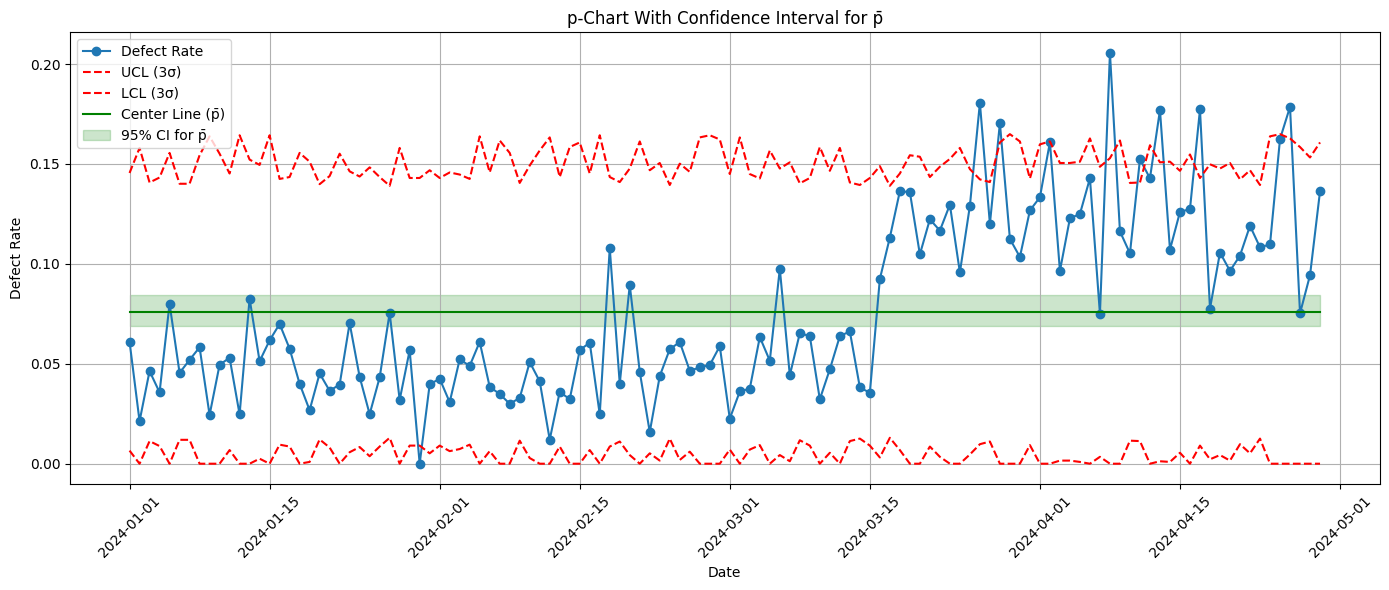

In [19]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label = 'Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')

plt.fill_between(
    df['Date'], ci_lower, ci_upper,
    color = 'green', alpha=0.2, label="95% CI for p̄"
)

plt.title('p-Chart With Confidence Interval for p̄')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

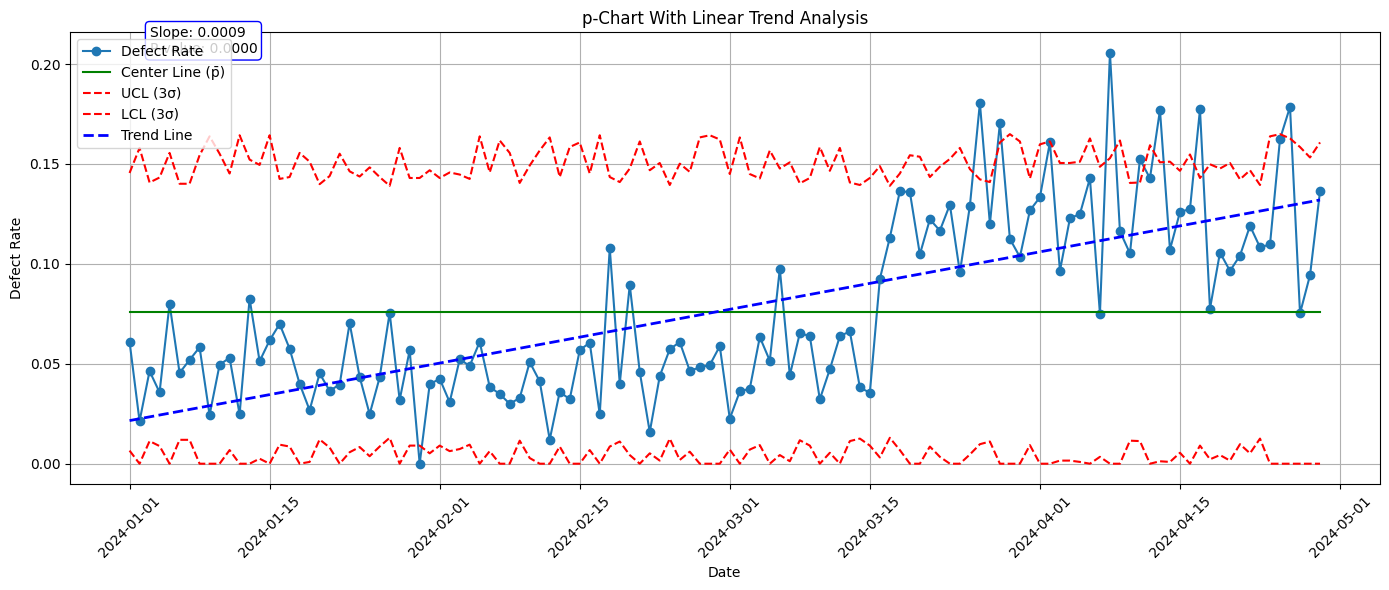

In [22]:
from scipy.stats import linregress

df['Day'] = range(1, len(df) + 1)

trend_result = linregress(df['Day'], df['Defect_Rate'])

slope = trend_result.slope
p_value = trend_result.pvalue
intercept = trend_result.intercept

df['Trend_Line'] = slope * df['Day'] + intercept # y = mx + c

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label = 'Defect Rate')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')


plt.plot(df['Date'], df['Trend_Line'], linestyle='--', color='blue', linewidth = 2, label = 'Trend Line')

plt.text(df['Date'].iloc[2], max(df['Defect_Rate']),
        f"Slope: {slope:.4f}\nP-value: {p_value:.4f}",
        fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round'))

plt.title('p-Chart With Linear Trend Analysis')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

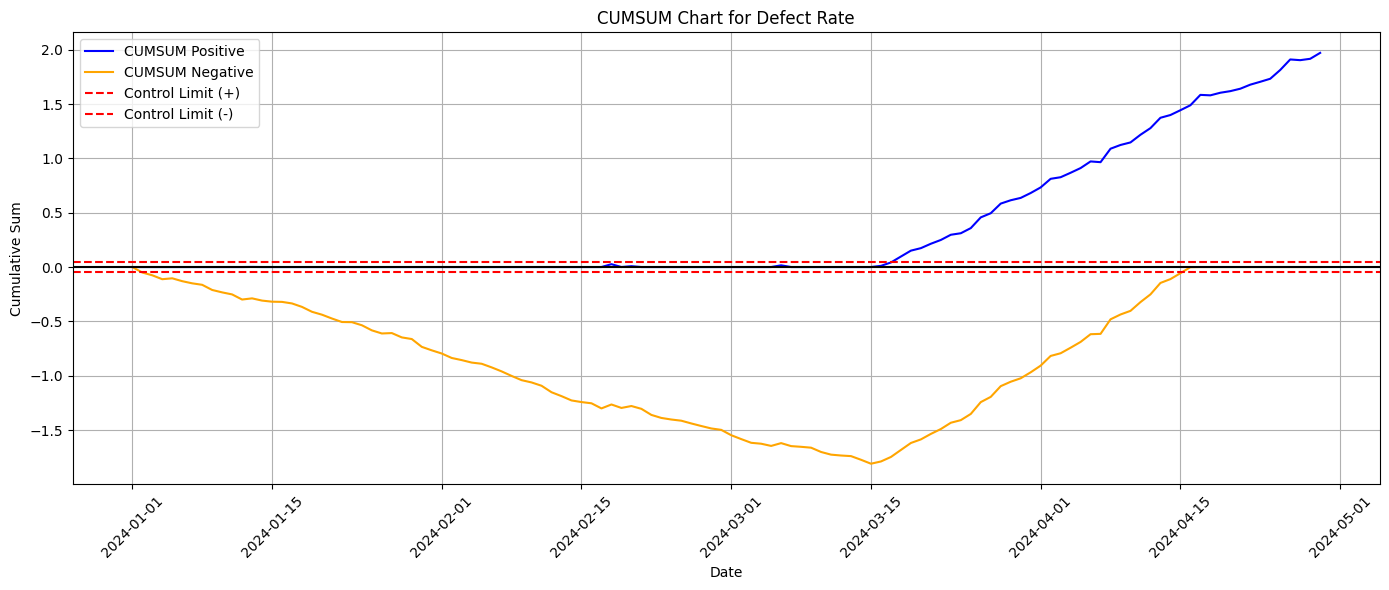

In [23]:
target = df['Defect_Rate'].mean()
k = 0.005
h = 0.05

cumsum_pos = [0]
cumsum_neg = [0]

for i in range(1, len(df)):
    p_i = df.loc[i, 'Defect_Rate']
    s_pos = max(0, cumsum_pos[-1] + (p_i - target - k))
    s_neg = min(0, cumsum_neg[-1] + (p_i - target + k))
    cumsum_pos.append(s_pos)
    cumsum_neg.append(s_neg)

df['CUMSUM_Pos'] = cumsum_pos
df['CUMSUM_Neg'] = cumsum_neg

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['CUMSUM_Pos'], label = 'CUMSUM Positive', color='blue')
plt.plot(df['Date'], df['CUMSUM_Neg'], color='orange', label='CUMSUM Negative')

plt.axhline(h, color='red', linestyle = '--', label = 'Control Limit (+)')
plt.axhline(-h, color='red', linestyle = '--', label = 'Control Limit (-)')
plt.axhline(0, color='black', linestyle = '-')

plt.title('CUMSUM Chart for Defect Rate')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

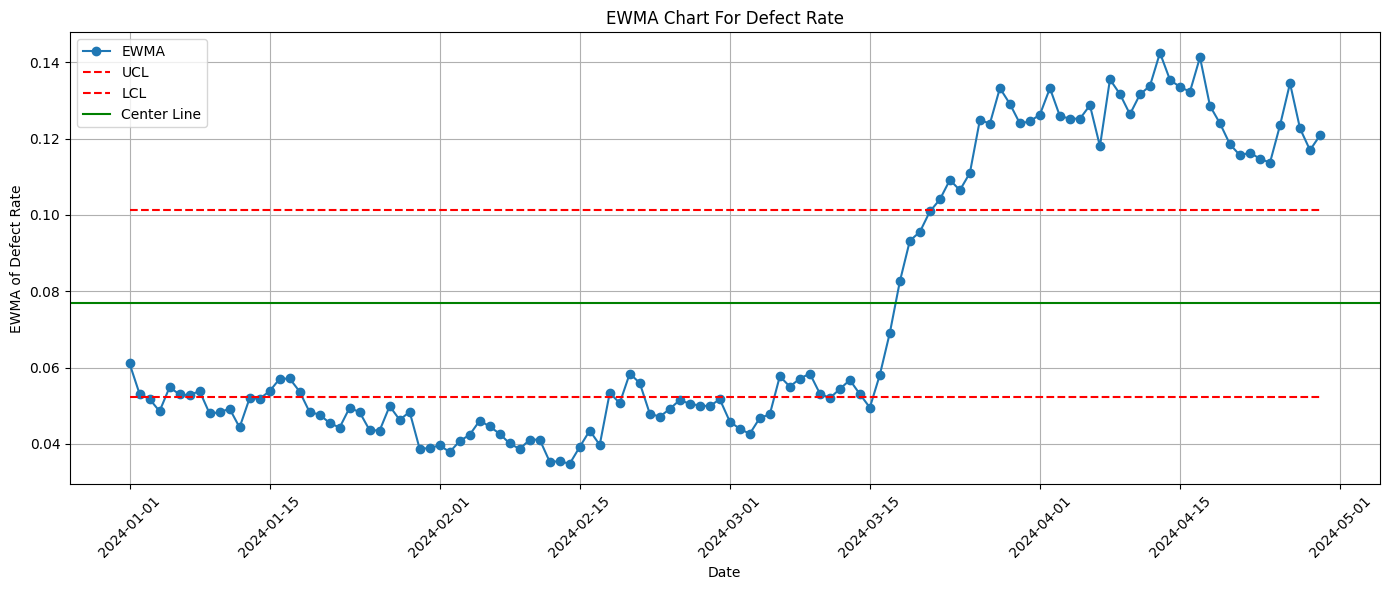

In [24]:
lambda_ = 0.2
L=3

df['EWMA'] = 0.3
df.loc[0, 'EWMA'] = df.loc[0, 'Defect_Rate']

for i in range(1, len(df)):
    df.loc[i, 'EWMA'] = lambda_ * df.loc[i, 'Defect_Rate'] + (1 - lambda_) * df.loc[i-1, 'EWMA']

p_bar = df['Defect_Rate'].mean()
avg_n = df['Sample_Size'].mean()
sigma = np.sqrt((p_bar * (1 - p_bar)) / avg_n)

df['UCL_EWMA'] = p_bar + L * sigma * np.sqrt(lambda_ / (2 - lambda_))
df['LCL_EWMA'] = p_bar - L * sigma * np.sqrt(lambda_ / (2 - lambda_))

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['EWMA'], marker = 'o', label = 'EWMA')
plt.plot(df['Date'], df['UCL_EWMA'], linestyle = '--', color='red', label='UCL')
plt.plot(df['Date'], df['LCL_EWMA'], linestyle = '--', color='red', label='LCL')
plt.axhline(p_bar, color='green', linestyle = '-', label = 'Center Line')

plt.title('EWMA Chart For Defect Rate')
plt.xlabel('Date')
plt.ylabel('EWMA of Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

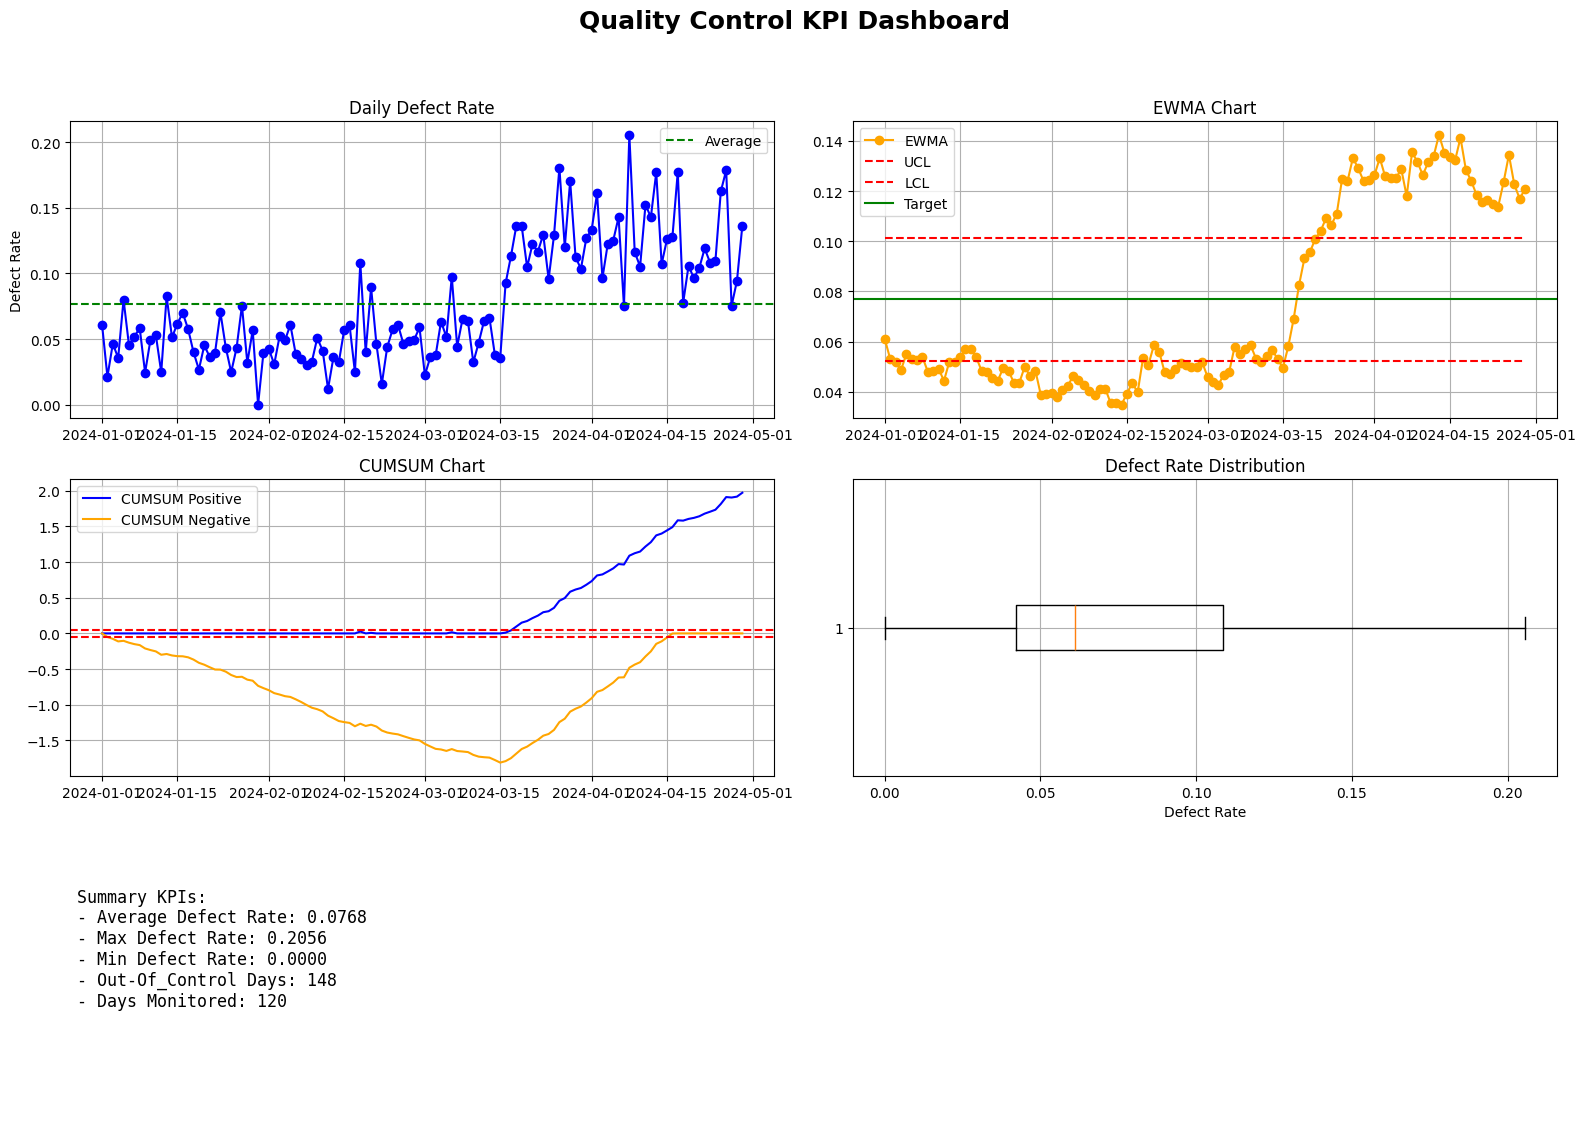

In [25]:
avg_defect_rate = df['Defect_Rate'].mean()
max_defect_rate = df['Defect_Rate'].max()
min_defect_rate = df['Defect_Rate'].min()
out_of_control_days = (df['CUMSUM_Pos'] > 0.05).sum() + (df['CUMSUM_Neg'] < -0.05).sum()

fig, axs = plt.subplots(3,2, figsize=(16,12))
fig.suptitle('Quality Control KPI Dashboard', fontsize = 18, fontweight = 'bold')

axs[0,0].plot(df['Date'], df['Defect_Rate'], marker='o', color= 'blue')
axs[0,0].axhline(avg_defect_rate, color='green', linestyle = '--', label = 'Average')
axs[0,0].set_title('Daily Defect Rate')
axs[0,0].set_ylabel('Defect Rate')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].plot(df['Date'], df['EWMA'], marker = 'o', label = 'EWMA', color='orange')
axs[0,1].plot(df['Date'], df['UCL_EWMA'], linestyle = '--', color='red', label='UCL')
axs[0,1].plot(df['Date'], df['LCL_EWMA'], linestyle = '--', color='red', label='LCL')
axs[0,1].axhline(avg_defect_rate, color='green', linestyle = '-', label = 'Target')
axs[0,1].set_title('EWMA Chart')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].plot(df['Date'], df['CUMSUM_Pos'], label = 'CUMSUM Positive', color = 'blue')
axs[1,0].plot(df['Date'], df['CUMSUM_Neg'], color='orange', label='CUMSUM Negative')
axs[1,0].axhline(0.05, color = 'red', linestyle = '--')
axs[1,0].axhline(-0.05, color = 'red', linestyle = '--')
axs[1,0].set_title('CUMSUM Chart')
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].boxplot(df['Defect_Rate'], vert = False)
axs[1,1].set_title('Defect Rate Distribution')
axs[1,1].set_xlabel('Defect Rate')
axs[1,1].grid(True)

axs[2,0].axis('off')
kpi_text = f"""
Summary KPIs:
- Average Defect Rate: {avg_defect_rate:.4f}
- Max Defect Rate: {max_defect_rate:.4f}
- Min Defect Rate: {min_defect_rate:.4f}
- Out-Of_Control Days: {out_of_control_days}
- Days Monitored: {len(df)}"""

axs[2,0].text(0.01, 0.9, kpi_text, fontsize=12, verticalalignment='top', family = 'monospace')

axs[2,1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()